# Ensemble Learning through Batch Boosting


In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# add project root folder to path to allow import local modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import local modules
from stochastic_models import *
from visualisations import *

## Parameter Configuration

In [3]:
np.random.seed(2020)

In [44]:
N_train = 1000
N_test = 10000
Epsilon  = 1e-6
Max_Iter = 50
Learning_Rate = 0.366
Ratio = 0.15
d = 1
T = 2

In [45]:
lambda_range = (N_train*1e-9 , N_train*1e-3)
alpha_range = (8.3*1e-5, 0.83)
length_scale = np.sort(1/np.sqrt((2*alpha_range[0], 2*alpha_range[1])))

## Create Kernel & prepare datasets

In [46]:
#kernel
kernel = RBF(length_scale= (length_scale[0] + length_scale[1])/2, length_scale_bounds=length_scale) \
        + WhiteKernel(noise_level= (lambda_range[0] + lambda_range[1])/2 , noise_level_bounds=lambda_range)


In [47]:
#generate drivers
s_train = MaxCallStochasticModel(N_train,d,[1/12,11/12])
s_train.generate_samples()
s_test = MaxCallStochasticModel(N_test, d, [1/12,11/12])
s_test.generate_samples()

In [48]:
y_train = s_train.y
X_train = s_train.X
S_train = s_train.S

y_test = s_test.y
X_test = s_test.X
S_test = s_test.S

V_T = s_test.generate_true_V(T)
V_0 = s_test.generate_true_V(0)

V_T_train = s_train.generate_true_V(T)
V_0_train = s_train.generate_true_V(0)

V_0_train = V_0_train.mean()
V_0= V_0.mean()
V_0 # Average expected PROFIT!

0.07971145712536395

In [49]:
from aggregating.utils import flatten_X, normalized_error_VT
#dim(N_test,d*T)
Flattened_X_test = flatten_X(X_test)
# dim(N_train, d*T)
Flattened_X_train = flatten_X(X_train)

In [50]:
#Model with Flatten_X_1
m_1 = GaussianProcessRegressor(kernel)
m_1.fit(Flattened_X_train,y_train)

GaussianProcessRegressor(kernel=RBF(length_scale=39.2) + WhiteKernel(noise_level=0.5))

In [51]:
fX_1 = m_1.predict(Flattened_X_test)

In [52]:
fX_2 = m_1.predict(Flattened_X_train)

In [53]:
test_reference_error = normalized_error_VT(fX_1 ,V_T, V_0)

In [54]:
train_reference_error = normalized_error_VT(fX_2 ,V_T_train, V_0_train)

In [55]:
train_reference_error

0.021564910045606366

In [56]:
test_reference_error

0.2138683235526514

## Stochastic Gradient Boosting

In [57]:
def Stochastic_Gradient_Boosting_0(X_train, y_train, X_test, y_test, Max_Iter, min_error, early_stop, kernel, learning_rate, epsilon, sample_size):
    error_going_up = 0
    train_prediction = np.zeros(N_train)
    test_prediction = np.zeros(N_test)
    previous_y_hat = np.zeros(N_train)
    previous_y_test_hat = np.zeros(N_test)
    models = []
    train_errors = []
    test_errors = []
    
    current_residual = np.full(len(y_train), 0.0)
    y_hat_test = np.full(len(y_test),0.0)

   
    
    for i in range(Max_Iter):
        model = GaussianProcessRegressor(kernel)
    
        indices = np.random.choice(X_train.shape[0],size=sample_size,replace=False)
       
        model.fit(X_train[indices], y_train[indices] - current_residual[indices])
        models.append(model)
        
        new_train_predictor = model.predict(X_train)
        new_test_predictor = model.predict(X_test)
        
        current_residual += learning_rate * new_train_predictor
        
        y_hat_train = current_residual 
        
        y_hat_test += learning_rate * new_test_predictor
        
        #Evaluating TrainSet error
        
        train_errors.append(normalized_error_VT(y_hat_train,y_train,V_0_train).item())
        
        ##Evaluating TestSet error
        
        test_errors.append(normalized_error_VT(y_hat_test,y_test,V_0).item())
    
        if (( np.abs(min_error[0] - test_errors[-1]) > epsilon) & (test_errors[-1] < min_error[0])):
            min_error = (test_errors[-1], i)
            error_going_up = 0
            print('For iteration number {}, the test error decreased , test error : {} '.format(i, min_error[0]))
        else:
            error_going_up += 1
            print('For iteration number {}, the test error increased , test error : {} '.format(i, min_error[0]))
        
            if  (i==(Max_Iter-1)):
                models = models[:min_error[1]+1]
                
                return models, train_errors, test_errors, min_error
        
            elif (error_going_up == early_stop ):
                models = models[: -(early_stop)]
                
                return models, train_errors, test_errors, min_error
                break #early stopping
            
    return models, train_errors, test_errors, min_error

In [58]:
models , train_error, test_error, min_error = Stochastic_Gradient_Boosting_0(np.copy(Flattened_X_train), np.copy(y_train), np.copy(Flattened_X_test), np.copy(y_test), Max_Iter, (float("inf"), float("inf")), 5, kernel, Learning_Rate, Epsilon, round(Flattened_X_train.shape[0]*Ratio))


For iteration number 0, the test error decreased , test error : 1.205096826930465 
For iteration number 1, the test error decreased , test error : 0.7714967578255285 
For iteration number 2, the test error decreased , test error : 0.502219608510035 
For iteration number 3, the test error decreased , test error : 0.33847874330771843 
For iteration number 4, the test error decreased , test error : 0.2395730920830932 
For iteration number 5, the test error decreased , test error : 0.18234157691248445 
For iteration number 6, the test error decreased , test error : 0.15213907207033733 
For iteration number 7, the test error decreased , test error : 0.13523698712622276 
For iteration number 8, the test error decreased , test error : 0.1292936836696414 
For iteration number 9, the test error decreased , test error : 0.12262011628379335 
For iteration number 10, the test error decreased , test error : 0.1184051145031822 
For iteration number 11, the test error decreased , test error : 0.11604

In [59]:
def Stochastic_Gradient_Boosting_1(X_train, y_train, X_test, y_test, Max_Iter, min_error, early_stop, kernel, learning_rate, epsilon, sample_size):
    error_going_up = 0
    train_prediction = np.zeros(N_train)
    test_prediction = np.zeros(N_test)
    previous_y_hat = np.zeros(N_train)
    previous_y_test_hat = np.zeros(N_test)
    models = []
    train_errors = []
    test_errors = []
    
    current_residual = np.full(len(y_train), np.mean(y_train, axis=0)/2)
    y_hat_test = np.full(len(y_test), np.mean(y_train, axis=0)/2)

   
    
    for i in range(Max_Iter):
        model = GaussianProcessRegressor(kernel)
    
        indices = np.random.choice(X_train.shape[0],size=sample_size,replace=False)
       
        model.fit(X_train[indices], y_train[indices] - current_residual[indices])
        models.append(model)
        
        new_train_predictor = model.predict(X_train)
        new_test_predictor = model.predict(X_test)
        
        current_residual += learning_rate * new_train_predictor
        
        y_hat_train = current_residual 
        
        y_hat_test += learning_rate * new_test_predictor
        
        #Evaluating TrainSet error
        
        train_errors.append(normalized_error_VT(y_hat_train,y_train,V_0_train).item())
        
        ##Evaluating TestSet error
        
        test_errors.append(normalized_error_VT(y_hat_test,y_test,V_0).item())
    
        if (( np.abs(min_error[0] - test_errors[-1]) > epsilon) & (test_errors[-1] < min_error[0])):
            min_error = (test_errors[-1], i)
            error_going_up = 0
            print('For iteration number {}, the test error decreased , test error : {} '.format(i, min_error[0]))
        else:
            error_going_up += 1
            print('For iteration number {}, the test error increased , test error : {} '.format(i, min_error[0]))
        
            if  (i==(Max_Iter-1)):
                models = models[:min_error[1]+1]
                
                return models, train_errors, test_errors, min_error
        
            elif (error_going_up == early_stop ):
                models = models[: -(early_stop)]
                
                return models, train_errors, test_errors, min_error
                break #early stopping
            
    return models, train_errors, test_errors, min_error

In [60]:
models , train_error, test_error, min_error = Stochastic_Gradient_Boosting_1(np.copy(Flattened_X_train), np.copy(y_train), np.copy(Flattened_X_test), np.copy(y_test), Max_Iter, (float("inf"), float("inf")), 5, kernel, Learning_Rate, Epsilon, round(Flattened_X_train.shape[0]*Ratio))


For iteration number 0, the test error decreased , test error : 1.0947093485713584 
For iteration number 1, the test error decreased , test error : 0.6980972903146958 
For iteration number 2, the test error decreased , test error : 0.4686705257479389 


/Users/Clement/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


For iteration number 3, the test error decreased , test error : 0.32763624846164685 
For iteration number 4, the test error decreased , test error : 0.23740585790561308 
For iteration number 5, the test error decreased , test error : 0.18410642825774418 
For iteration number 6, the test error decreased , test error : 0.1674910138639983 
For iteration number 7, the test error decreased , test error : 0.15225788022035874 
For iteration number 8, the test error decreased , test error : 0.14494789976450265 
For iteration number 9, the test error decreased , test error : 0.14134082595504183 
For iteration number 10, the test error decreased , test error : 0.13995097262733752 
For iteration number 11, the test error decreased , test error : 0.13807647208147705 
For iteration number 12, the test error decreased , test error : 0.13797373677337 
For iteration number 13, the test error decreased , test error : 0.13738811693019926 
For iteration number 14, the test error decreased , test error : 

In [61]:
def Stochastic_Gradient_Boosting(X_train, y_train, X_test, y_test, Max_Iter, min_error, early_stop, kernel, learning_rate, epsilon, sample_size):
    error_going_up = 0
    train_prediction = np.zeros(N_train)
    test_prediction = np.zeros(N_test)
    previous_y_hat = np.zeros(N_train)
    previous_y_test_hat = np.zeros(N_test)
    models = []
    train_errors = []
    test_errors = []
    
    current_residual = np.full(len(y_train), np.mean(y_train, axis=0))
    y_hat_test = np.full(len(y_test), np.mean(y_train, axis=0))

   
    
    for i in range(Max_Iter):
        model = GaussianProcessRegressor(kernel)
    
        indices = np.random.choice(X_train.shape[0],size=sample_size,replace=False)
       
        model.fit(X_train[indices], y_train[indices] - current_residual[indices])
        models.append(model)
        
        new_train_predictor = model.predict(X_train)
        new_test_predictor = model.predict(X_test)
        
        current_residual += learning_rate * new_train_predictor
        
        y_hat_train = current_residual 
        
        y_hat_test += learning_rate * new_test_predictor
        
        #Evaluating TrainSet error
        
        train_errors.append(normalized_error_VT(y_hat_train,y_train,V_0_train).item())
        
        ##Evaluating TestSet error
        
        test_errors.append(normalized_error_VT(y_hat_test,y_test,V_0).item())
    
        if (( np.abs(min_error[0] - test_errors[-1]) > epsilon) & (test_errors[-1] < min_error[0])):
            min_error = (test_errors[-1], i)
            error_going_up = 0
            print('For iteration number {}, the test error decreased , test error : {} '.format(i, min_error[0]))
        else:
            error_going_up += 1
            print('For iteration number {}, the test error increased , test error : {} '.format(i, min_error[0]))
        
            if  (i==(Max_Iter-1)):
                models = models[:min_error[1]+1]
                
                return models, train_errors, test_errors, min_error
        
            elif (error_going_up == early_stop ):
                models = models[: -(early_stop)]
                
                return models, train_errors, test_errors, min_error
                break #early stopping
            
    return models, train_errors, test_errors, min_error

In [62]:
models , train_error, test_error, min_error = Stochastic_Gradient_Boosting(np.copy(Flattened_X_train), np.copy(y_train), np.copy(Flattened_X_test), np.copy(y_test), Max_Iter, (float("inf"), float("inf")), 5, kernel, Learning_Rate, Epsilon, round(Flattened_X_train.shape[0]*Ratio))


For iteration number 0, the test error decreased , test error : 1.0926991708270974 
For iteration number 1, the test error decreased , test error : 0.6998605407609697 
For iteration number 2, the test error decreased , test error : 0.46492352904754725 
For iteration number 3, the test error decreased , test error : 0.3220593320295523 
For iteration number 4, the test error decreased , test error : 0.23658886483021435 
For iteration number 5, the test error decreased , test error : 0.19287955285641578 
For iteration number 6, the test error decreased , test error : 0.16729200476464937 
For iteration number 7, the test error decreased , test error : 0.15436666159935641 
For iteration number 8, the test error decreased , test error : 0.15154076295244198 
For iteration number 9, the test error decreased , test error : 0.14680807500846912 
For iteration number 10, the test error decreased , test error : 0.11757477073834778 
For iteration number 11, the test error decreased , test error : 0.

In [91]:
learning_rates = np.linspace(0.1, 0.5 , num=10)

In [92]:
models = dict((val, []) for val in range(len(learning_rates))) 
train_errors = dict((val, []) for val in range(len(learning_rates))) 
test_errors = dict((val, []) for val in range(len(learning_rates))) 
min_errors = dict((val, []) for val in range(len(learning_rates))) 

for i in range(len(learning_rates)) :
    models[i], train_errors[i], test_errors[i], min_errors[i] = Stochastic_Gradient_Boosting(np.copy(Flattened_X_train), np.copy(y_train), np.copy(Flattened_X_test), np.copy(y_test), Max_Iter, (float("inf"), float("inf")), 5, kernel, learning_rates[i], Epsilon, round(Flattened_X_train.shape[0]*Ratio))


For iteration number 0, the test error decreased , test error : 1.4952360560183375 
For iteration number 1, the test error decreased , test error : 1.3499074041300279 
For iteration number 2, the test error decreased , test error : 1.2178288700379385 
For iteration number 3, the test error decreased , test error : 1.093659174799127 
For iteration number 4, the test error decreased , test error : 0.9817091519596772 
For iteration number 5, the test error decreased , test error : 0.881711843176489 
For iteration number 6, the test error decreased , test error : 0.7954136797135344 
For iteration number 7, the test error decreased , test error : 0.7195322085221106 
For iteration number 8, the test error decreased , test error : 0.6518270231607383 
For iteration number 9, the test error decreased , test error : 0.5931660805902992 
For iteration number 10, the test error decreased , test error : 0.5340291251793181 
For iteration number 11, the test error decreased , test error : 0.4843819215

For iteration number 96, the test error decreased , test error : 0.1036304970941646 
For iteration number 97, the test error increased , test error : 0.1036304970941646 
For iteration number 98, the test error increased , test error : 0.1036304970941646 
For iteration number 99, the test error increased , test error : 0.1036304970941646 
For iteration number 0, the test error decreased , test error : 1.4257973244993785 
For iteration number 1, the test error decreased , test error : 1.225637871130961 
For iteration number 2, the test error decreased , test error : 1.0687368317510553 
For iteration number 3, the test error decreased , test error : 0.915664038454133 
For iteration number 4, the test error decreased , test error : 0.7846695703602047 
For iteration number 5, the test error decreased , test error : 0.6763812230255174 
For iteration number 6, the test error decreased , test error : 0.5832219690039041 
For iteration number 7, the test error decreased , test error : 0.50458084

For iteration number 23, the test error decreased , test error : 0.10689007665879685 
For iteration number 24, the test error decreased , test error : 0.10648948249890404 
For iteration number 25, the test error decreased , test error : 0.10616905436879669 
For iteration number 26, the test error decreased , test error : 0.10567888373871517 
For iteration number 27, the test error decreased , test error : 0.1054795809561849 
For iteration number 28, the test error decreased , test error : 0.10529926875838523 
For iteration number 29, the test error decreased , test error : 0.10514245566669252 
For iteration number 30, the test error decreased , test error : 0.10510555220410771 
For iteration number 31, the test error decreased , test error : 0.10489417732586603 
For iteration number 32, the test error decreased , test error : 0.10478014428254794 
For iteration number 33, the test error decreased , test error : 0.10466142634405966 
For iteration number 34, the test error decreased , tes

For iteration number 27, the test error decreased , test error : 0.08753004104367652 
For iteration number 28, the test error increased , test error : 0.08753004104367652 
For iteration number 29, the test error increased , test error : 0.08753004104367652 
For iteration number 30, the test error decreased , test error : 0.08747752275466973 
For iteration number 31, the test error decreased , test error : 0.08742008861364363 


/Users/Clement/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


For iteration number 32, the test error decreased , test error : 0.08740746656423284 
For iteration number 33, the test error increased , test error : 0.08740746656423284 
For iteration number 34, the test error increased , test error : 0.08740746656423284 
For iteration number 35, the test error increased , test error : 0.08740746656423284 
For iteration number 36, the test error increased , test error : 0.08740746656423284 
For iteration number 37, the test error increased , test error : 0.08740746656423284 
For iteration number 0, the test error decreased , test error : 1.1309317873156335 
For iteration number 1, the test error decreased , test error : 0.778807344197644 
For iteration number 2, the test error decreased , test error : 0.5421224687317979 
For iteration number 3, the test error decreased , test error : 0.3830565227504281 
For iteration number 4, the test error decreased , test error : 0.27547879262282254 
For iteration number 5, the test error decreased , test error : 

/Users/Clement/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


For iteration number 8, the test error decreased , test error : 0.13421428911138358 
For iteration number 9, the test error decreased , test error : 0.1266343298403705 
For iteration number 10, the test error decreased , test error : 0.12230903141509816 
For iteration number 11, the test error decreased , test error : 0.12014517693706014 
For iteration number 12, the test error decreased , test error : 0.1187236165384464 
For iteration number 13, the test error decreased , test error : 0.1181461312519674 
For iteration number 14, the test error decreased , test error : 0.11740992159806679 
For iteration number 15, the test error decreased , test error : 0.11717111397788241 
For iteration number 16, the test error decreased , test error : 0.11713419549777773 
For iteration number 17, the test error decreased , test error : 0.11711057531642195 
For iteration number 18, the test error decreased , test error : 0.11686022004325577 
For iteration number 19, the test error increased , test er

For iteration number 0, the test error decreased , test error : 0.8653144136687084 
For iteration number 1, the test error decreased , test error : 0.45270216330702556 
For iteration number 2, the test error decreased , test error : 0.2572679609648998 
For iteration number 3, the test error decreased , test error : 0.1749540076472828 
For iteration number 4, the test error decreased , test error : 0.14154919901024396 
For iteration number 5, the test error decreased , test error : 0.13155828953099652 
For iteration number 6, the test error decreased , test error : 0.12834989340039563 
For iteration number 7, the test error decreased , test error : 0.12725627604657683 
For iteration number 8, the test error decreased , test error : 0.12660106798043871 
For iteration number 9, the test error decreased , test error : 0.1265348783936404 
For iteration number 10, the test error decreased , test error : 0.12650786271810036 
For iteration number 11, the test error decreased , test error : 0.1

In [120]:
for i in range(len(test_errors)):
    while len(test_errors[i]) != Max_Iter :
        test_errors[i].append(test_errors[i][-1])


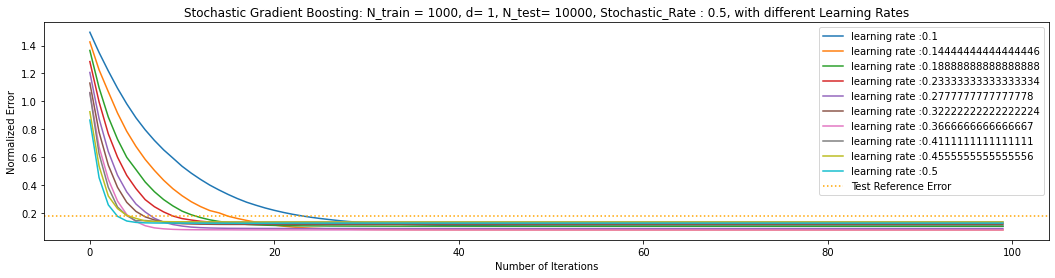

In [123]:
plt.figure(figsize=((18, 4)))
for i in range(len(learning_rates)) :
    plt.plot(np.arange(len(test_errors[i][:])) , test_errors[i][:], label = f'learning rate :{learning_rates[i]}')
plt.axhline(test_reference_error, ls=':', color = 'orange', label = 'Test Reference Error')
plt.xlabel("Number of Iterations")
plt.title(f"Stochastic Gradient Boosting: N_train = {N_train}, d= {d}, N_test= {N_test}, Stochastic_Rate : {Ratio}, with different Learning Rates")
plt.ylabel("Normalized Error")
plt.legend(loc='upper right')
plt.show()

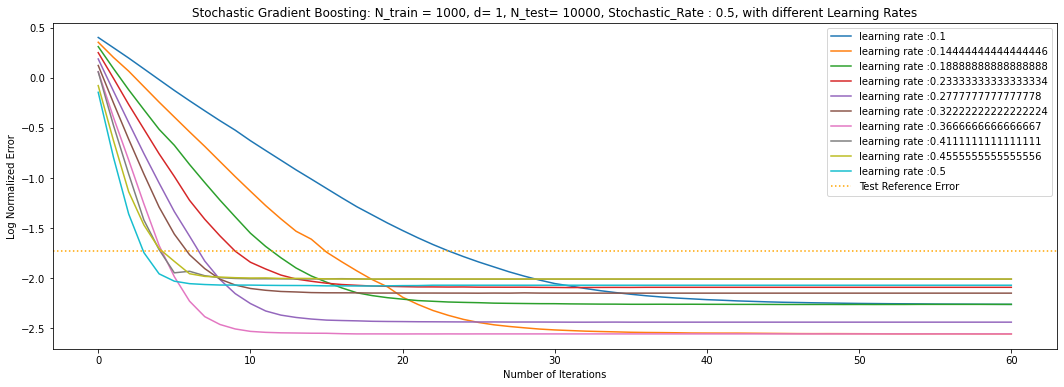

In [125]:
plt.figure(figsize=((18, 6)))
for i in range(len(learning_rates)) :
    #plt.axvline(min_errors[i][1], ls='-', color = 'k', label = 'Test Minimal Error for rate : {rate}')
    plt.plot(np.arange(len(test_errors[i][:61])) , np.log(test_errors[i][:61]), label = f'learning rate :{learning_rates[i]}')
plt.axhline(np.log(test_reference_error), ls=':', color = 'orange', label = 'Test Reference Error')
plt.xlabel("Number of Iterations")
plt.title(f"Stochastic Gradient Boosting: N_train = {N_train}, d= {d}, N_test= {N_test}, Stochastic_Rate : {Ratio}, with different Learning Rates")
plt.ylabel("Log Normalized Error")
plt.legend(loc='upper right')
plt.show()

In [81]:
Stochastic_Boost_error = min_error[0]

In [83]:
test_reference_error-Stochastic_Boost_error

0.10481287592934688

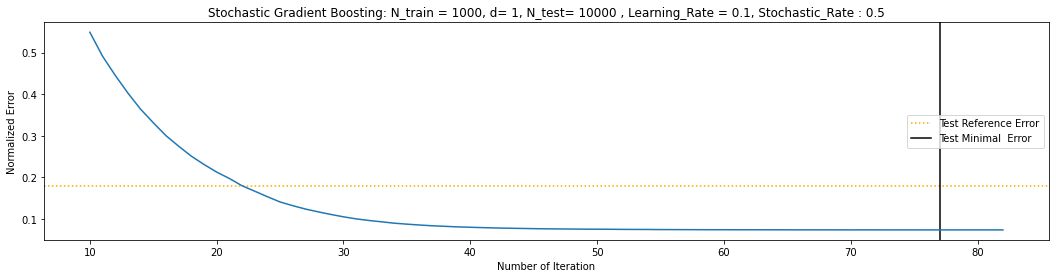

In [95]:
plt.figure(figsize = (18, 4))
plt.axhline(test_reference_error, ls=':', color = 'orange', label = 'Test Reference Error')
plt.axvline(min_error[1], ls='-', color = 'k', label = 'Test Minimal  Error')
plt.plot(np.arange(10,len(test_error[:])) , test_error[10:])
plt.title(f"Stochastic Gradient Boosting: N_train = {N_train}, d= {d}, N_test= {N_test} , Learning_Rate = {Learning_Rate}, Stochastic_Rate : {Ratio}")
plt.xlabel("Number of Iteration")

plt.ylabel("Normalized Error")
plt.legend(loc='center right')
plt.show()

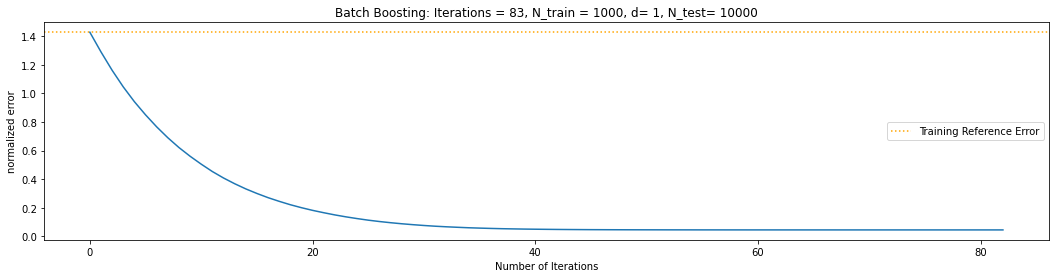

In [85]:
plt.figure(figsize = (18, 4))
plt.axhline(train_error[0], ls=':', color = 'orange', label = 'Training Reference Error')
plt.plot(np.arange(len(train_error)) ,train_error)
plt.title(f"Batch Boosting: Iterations = {len(train_error)}, N_train = {N_train}, d= {d}, N_test= {N_test}")
plt.xlabel("Number of Iterations")

plt.ylabel("normalized error")
plt.legend(loc='center right')
plt.show()